In [1]:
library(magrittr)
library(tidyverse)
source("../data/env/variables.R")
source("~/wisdom/r/clean_theme.R")

options("readr.num_columns" = 0)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
tumor <- "luad"

switches.tumor <- switches.split %>%
    filter(Tumor == tumor)
pats <- lapply(switches.tumor$Patients_affected, function(x) strsplit(x, ",") %>% unlist )

psi <- paste0("../data/psidiff/", tumor, "/psi.diff.txt") %>%
    read.table(check.names=FALSE) %>%
    mutate(., tx = rownames(.) %>% strsplit(",") %>% unlist %>% subset(c(F,T))) %>%
    filter(tx %in% unique(c(switches.tumor$Normal_transcript,switches.tumor$Tumor_transcript))) %>%
    gather(tx) %>% 
    set_colnames(c("tx","patient","deltapsi"))

psi.p <- paste0("../data/psidiff/", tumor, "/psi.diff.p.txt") %>%
    read.table(check.names=FALSE) %>%
    mutate(., tx = rownames(.) %>% strsplit(",") %>% unlist %>% subset(c(F,T))) %>%
    filter(tx %in% unique(c(switches.tumor$Normal_transcript, switches.tumor$Tumor_transcript))) %>%
    gather(tx) %>% 
    set_colnames(c("tx","patient","p"))
    
switches.tumor <- switches.tumor %>% filter(Normal_transcript %in% psi$tx & Tumor_transcript %in% psi$tx)
pats <- lapply(switches.tumor$Patients_affected, function(x) strsplit(x, ",") %>% unlist )
    
d <- merge(psi, psi.p)

Warning message:
“attributes are not identical across measure variables; they will be dropped”

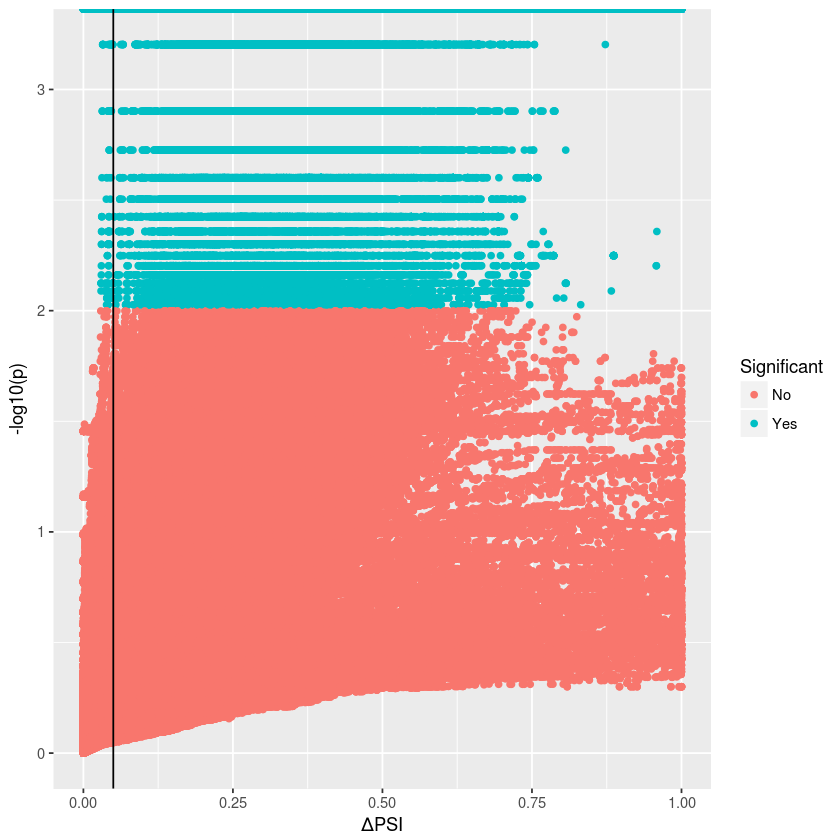

In [4]:
d %>%
    filter(!is.na(p)) %>%
    ggplot(aes(x = deltapsi, y = -log10(as.numeric(p)), color = ifelse(as.numeric(p) < 0.01, "Yes", "No"))) + 
        geom_point() +
        geom_vline(xintercept = 0.05) +
        labs(x = "ΔPSI", y = "-log10(p)", color = "Significant")